# Code Associated with Research Question 1

__Research Question 1__ <br>
"Is there a change in the low-frequency power between _not learned_ and _learned_ conditions?"

In [1]:
# common imports
import numpy as np
import os
import pickle
import json
import pandas
import time
import matplotlib.pyplot as plt

# time-frequency analysis
from scipy import signal
from scipy.fftpack import next_fast_len

# statistics
from scipy import stats, ndimage
import skimage

# own libraries
import neuropsy as npsy
import neuropsy.analysis as npsya
import neuropsy.statistics as npsystat

In [77]:
#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_save                   = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

# common parameters
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')

# analysis parameters
cond_column                 = 'Condition (modified)'
stimulus_list               = ['Picture Shown', 'Picture Placed']
tmin                        = -.5                   # time before stimulus
tmax                        = 2                     # time after stimulus
baseline                    = (-.2, 0.)              # time period from before stimulus to use for baseline correction
baseline_method             = 'mean'                # basline correction method (see neuropsy.preprocessing)

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 13, 1)
cycles                      = [8, 7, 6, 6, 5, 5, 5, 4, 4, 3, 3]
n_half_wavelet              = len(t_wl) // 2

# plot parameters
timepoints                  = np.arange(0, 1280, 1)
xticks                      = [0, 255, 511, 767, 1023, 1279]
xlabels                     = ["- 0.5 s", "stim", "0.5 s", "1 s", "1.5 s", "2 s"]
frequencies_plot            = np.insert(frequencies.astype(float), [0, len(frequencies)], [1.5, 12.5]) # define custom y ticks across frequencies but exclude first and last frequency labels as they the ticks are only for plotting purposes
yticks                      = frequencies_plot
ylabels                     = [int(frequencies_plot[i]) if i > 0 and i < len(frequencies_plot)-1 else "" for i in range(len(frequencies_plot))]

# set up directory for saving results
if not os.path.exists(path_save):
    os.makedirs(path_save)
    os.makedirs(f"{path_save}/data")

# 1. Time-frequency Power Analysis 

General info
- Analyse Entire hippocampus
- Manual convolution
- 4 conditions ("not learned", "correct", "learned-1", "learned") 
- Two stimulus; onset is "picture shown" and offset is "picture placed"
- Baseline correct within trials (-1 s to -0.5 s before onset)

Processing info
- Trials with NaNs are identified in a previous preprocessing step and removed from the experiment dataframe
- Outliers trials are identified in a previous preprocessing step and excluded here during the analysis
- IED timepoints for each contact are identified in a previous preprocessing step and trials with IEDs are exluded here during the analysis

Steps:
1. Iterate over all subjects
2. Select contacts in the hippocampus
3. Compute time-frequency power for the channels in each subject
4. Exlude trials with IEDs
5. Cut trial epochs for each stimulus and the corresponding baseline period
6. Baseline correct trial epochs
7. Average time-frequency power across trials to obtain channel average per condition
8. Average time-frequency power across subjects and across channels to obtain condition average
9. Average all time-frequency power across all conditions to obtain total average

### 1.0 Decide Center Frequencies and Number of Cycles for Complex Morelet Wavelet

In [ ]:
def plot_wavelets(frequencies, cycles, t_wl, fs):
    
    nrows = np.floor(np.sqrt(len(frequencies))).astype(int)
    
    fig, ax = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    fig2, ax2 = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    ax = ax.flatten()
    ax2 = ax2.flatten()

    wavelet_funcs = {}
    for i, (f, n) in enumerate(zip(frequencies, cycles)):

        # create complex Morlet wavelet
        wavelet, gauss_env = npsya.morlet(f, n, t_wl, return_gaussian=True)
        wavelet_funcs[f] = wavelet
        
        # plot wavelet and gaussian envelope
        ax[i].plot(t_wl, gauss_env, ':', label='envelope', color='black')
        ax[i].plot(t_wl, wavelet.real, label='real')
        ax[i].plot(t_wl, wavelet.imag, label='imaginary', linestyle='--', linewidth=1.)
        ax[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax[i].set_ylabel('Amplitude')
        if i == 0:
            ax[-1].set_xlabel('Time (s)')
            ax[-2].set_xlabel('Time (s)')
            ax[-3].set_xlabel('Time (s)')
            ax[-4].set_xlabel('Time (s)')
        ax[i].legend(loc='upper right', shadow=True)
        
        # plot frequency spectrum
        xf, y = npsya.compute_fft(wavelet, fs, output='mag')
        ax2[i].plot(xf, y)
        ax2[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax2[i].set_ylabel('Magnitude')
        if i == 0:
            ax2[-1].set_xlabel('Frequency (Hz)')
            ax2[-2].set_xlabel('Frequency (Hz)')
            ax2[-3].set_xlabel('Frequency (Hz)')
            ax2[-4].set_xlabel('Frequency (Hz)')
        # ax2[i, j].set_yscale('log')
        ax2[i].set_xlim([-1, 40])
        # ax2[i, j].set_ylim([40, 120])
            
    fig.suptitle('Complex Morlet wavelet - Time Domain', fontsize=16, y=.92)
    fig2.suptitle('Complex Morlet wavelet - Frequency Domain', fontsize=16, y=.92)
    plt.show()
    
    
# ********* TEST FUNCTION ********* #
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n

# OLD
# frequencies                 = np.arange(2, 32, 2)
# cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])

# CURRENT
# frequencies                 = np.arange(2, 13, 1)
# cycles                      = [8, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3]

# TEST
frequencies                 = np.arange(2, 13, 1)
# cycles                      = [8, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3]
# cycles = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

plot_wavelets(frequencies, cycles, t_wl, fs)

### 1.1 Power Analysis

Code computes fft of a channel within a subject once, then iterates over conditions and trials.

In [3]:
for stimulus in stimulus_list:
    print(f"Starting analysis for stimulus {repr(stimulus)}...")

    # save general analysis info (will be saved as json file in the end)
    dict_analysis_info = {}
    dict_analysis_info['general'] = {}
    dict_analysis_info['general']['conditions'] = conditions
    dict_analysis_info['general']['cond_column'] = cond_column
    dict_analysis_info['general']['stimulus'] = stimulus
    dict_analysis_info['general']['tmin'] = tmin
    dict_analysis_info['general']['tmax'] = tmax
    dict_analysis_info['general']['baseline'] = baseline
    dict_analysis_info['general']['baseline_method'] = baseline_method
    dict_analysis_info['general']['wavelet'] = {'frequencies': frequencies.tolist(), 'cycles': cycles.tolist() if isinstance(cycles, np.ndarray) else cycles}

    # time-frequency result dictionary {condition: {subject_id: {channel: {trial: np.2darray}}}}
    dict_tfr_power_results = {c: {s: {} for s in subject_ids} for c in conditions}

    #********** START ANALYSIS **********#
    for subject_id in subject_ids:
        
        # initialise variables
        trial_names_outliers                = None
        labels_outliers                     = None
        dict_outliers                       = {}
        trial_names_too_short               = None
        trial_names_too_close               = None
        labels_too_short                    = None
        labels_too_close                    = None
        dict_too_short                      = {}
        dict_too_close                      = {}
        
        
        start_time_sub = time.time()
        print(f"\tStarting subject {subject_id}...")

        #********** LOAD SUBJECT DATA **********# 
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix='preprocessed')
        
        # subtract total mean from each channel to remove DC bias
        print("\tRemoving DC bias from iEEG data...")
        total_mean = np.mean(data.ieeg)
        for i in range(data.ieeg.shape[0]):
            data.ieeg[i, :] = data.ieeg[i, :] - total_mean
            data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
            
        #********** SELECT CHANNELS TO INCLUDE IN ANALYSIS **********# 
        print(f"\tSelecting channels in hippocampus...")
        ch_names = data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains('HP_head|HP_body|HP_tail', case=True)].name.to_list()
        # check that there are channels in the hippocampal subfield for this subject, otherwise skip
        if len(ch_names) > 0:
            data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
            print(f"\tSelected {len(ch_names)} channels in hippocampus.")
        else:
            print(f"\tNo channels in hippocampus.")
        
        #********** REMOVE OUTLIERS (TRIALS WITH TOO HIGH REACTION TIME)  **********# 
        print("\tRemoving outliers from experiment dataframe...")
        idx_outliers = data.df_exp[data.df_exp['outlier'] == True]['outlier'].index.to_list()
        if len(idx_outliers) > 0:
            trial_names_outliers    = data.df_exp[data.df_exp['outlier'] == True]['Trial Identifier'].to_list()
            labels_outliers         = data.df_exp.loc[idx_outliers, cond_column].to_list()
            for i, label in zip(idx_outliers, labels_outliers):
                if label not in dict_outliers.keys():
                    dict_outliers[label] = 1
                else:
                    dict_outliers[label] += 1
            for key, value in dict_outliers.items():
                print(f"{value} outliers in condition {repr(key)}.")
            data.df_exp = data.df_exp.drop(idx_outliers).reset_index(drop=True)
        else:
            print("\tNo outliers in experiment dataframe.")

        # [INFO] need to make sure trials have enough time points for the chosen tmax
        #********** CHECK TRIAL DURATIONS **********# 
        print("\tChecking trial durations...")
        idx_too_short, idx_too_close = npsya.check_trials(df=data.df_exp, col_name=cond_column, tmin=tmin, tmax=tmax, baseline=baseline)
        idx_drop = np.unique(np.concatenate((idx_too_short, idx_too_close))).astype(int).tolist()
        # trials with too few time points
        if len(idx_too_short) > 0:
            trial_names_too_short  = data.df_exp.loc[idx_too_short, 'Trial Identifier'].to_list()
            labels_too_short       = data.df_exp.loc[idx_too_short, cond_column].to_list()
            for i, label in zip(idx_too_short, labels_too_short):
                if label not in dict_too_short.keys():
                    dict_too_short[label] = 1
                else:
                    dict_too_short[label] += 1
            for key, value in dict_too_short.items():
                print(f"\t{value} are too short in condition {repr(key)}.")
        else:
            print("\tNo trials are too short.")
                
        # trials too close to other trials
        if len(idx_too_close) > 0:
            trial_names_too_close  = data.df_exp.loc[idx_too_close, 'Trial Identifier'].to_list()
            labels_too_close       = data.df_exp.loc[idx_too_close, cond_column].to_list()
            for i, label in zip(idx_too_close, labels_too_close):
                if label not in dict_too_close.keys():
                    dict_too_close[label] = 1
                else:
                    dict_too_close[label] += 1
            for key, value in dict_too_close.items():
                print(f"\t{value} are too close with other trials in condition {repr(key)}.")
        else:
            print("\tNo trials are too close.")

        #********** CREATE MNE RAW OBJECT WITH iEEG DATA **********#
        data.create_raw()
        

        #********** GET TRIAL TIME POINTS (INDICES) AND TRIAL IDENTIFIERS (NAMES) **********#
        # - need trial indices for conditions from experiment dataframe
        # - also need the corresponding trial indices for the baseline (picture shown)
        # - also need to extract the trial identifiers (names) to keep track of trials in the resulting time-frequency power data
        print("\tGetting trial indices...")
        dict_trial_indices = {**{f'{c}_stimulus': None for c in conditions}, **{f'{c}_baseline': None for c in conditions}, **{f'{c}_names': None for c in conditions}}
        for c in conditions:
            # get the trial indices for the condition
            idx_stimulus                            = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus}'].to_numpy().astype(int)
            idx_baseline                            = data.df_exp[data.df_exp[cond_column] == c]['Mark for Picture Shown'].to_numpy().astype(int)
            # save indices
            dict_trial_indices[f"{c}_stimulus"]     = idx_stimulus
            dict_trial_indices[f"{c}_baseline"]     = idx_baseline
            # get the trial identifiers (names) for the condition
            trial_names                             = data.df_exp[data.df_exp[cond_column] == c]['Trial Identifier'].to_numpy().astype(str)
            # save trial identifiers
            dict_trial_indices[f"{c}_names"]        = trial_names


        #********** TIME-FREQUENCY ANALYSIS **********#
        # info
        dict_n_trials_kept = None
        dict_n_trials_ieds = None
        
        if len(ch_names) > 0:
            
            # info
            dict_n_trials_kept = {f'{c}': {**{f'{ch}': 0 for ch in ch_names}, **{'total': 0}} for c in conditions}
            dict_n_trials_ieds = {f'{c}': {**{f'{ch}': 0 for ch in ch_names}, **{'total': 0}} for c in conditions}
            
            # CHANNEL:
            #  - FFT of entire channel signal
            #  - CWT for each frequency and cycle
            #  - store power in dB for each frequency
            #  - this is done once per channel, then afterwards each trial is considered independently during CONDITION loop
            #    - this is done to save time as the CWT is the most time-consuming part
            for ch in ch_names:
                start_time_ch = time.time()
                print(f"\t\tStarting channel {ch}...")
                
                # use the whole channel signal for computing time-frequency representation
                ch_signal = data.raw._data[ch_names.index(ch), ...]
                
                # ********* FFT of CHANNEL ********* #
                n_conv      = len(t_wl) + len(ch_signal) - 1
                n_conv_fast = next_fast_len(n_conv)
                signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
                
                # initialise output data for continuous wavelet transform
                tf_data = np.zeros((len(frequencies), len(ch_signal)))
                
                # ********* CWT ********* #
                for i, (f, n) in enumerate(zip(frequencies, cycles)):
                    
                    # [INFO] - print current wavelet parameters
                    # print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                    
                    # create wavelet
                    wavelet = npsya.morlet(f, n, t_wl)
                    
                    # fft of wavelet
                    # note:
                    #   output must match the length of the signal_fft in order to multiply in the frequency domain
                    wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                    
                    # convolution
                    coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                    coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                    coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                    
                    # convert to power in dB
                    tf_power = 10 * np.log10(np.abs(coefficients)**2)
                    
                    # store result for frequency
                    tf_data[i, :] = tf_power
                    
                # clean up
                del ch_signal, signal_fft, wavelet, wavelet_fft, coefficients, tf_power
                    
                # CONDITION:
                #  - continuous wavelet transform result is stored in tf_data (in dB)
                #  - now we need to consider each trial independently
                #  - loop over conditions
                #  - loop over trials in condition
                #  - baseline correction is done for each trial separately
                #  - the window between onset and offset is divided into bins
                for condition in conditions:
                    start_time_cond = time.time()
                    print(f"\t\t\tStarting condition {repr(condition)}...")
                    
                    dict_tfr_power_results[condition][subject_id][ch] = {}
                    
                    for (i_stimulus, i_baseline, trial_id) in zip(dict_trial_indices[f'{condition}_stimulus'], 
                                                                  dict_trial_indices[f'{condition}_baseline'], 
                                                                  dict_trial_indices[f'{condition}_names']):
                        start_time_trial = time.time()
                        
                        # get start and stop timepoints for trial period and baseline period
                        i_tmin = int(i_stimulus + int(tmin * fs))
                        i_tmax = int(i_stimulus + int(tmax * fs))
                        b_tmin = int(i_baseline + int(baseline[0] * fs))
                        b_tmax = int(i_baseline + int(baseline[1] * fs))
                        
                        #********** CHECK TRIAL FOR IEDs **********# 
                        # - if there are IEDs in the trial, skip it and exclude it from the analysis
                        # - if there are IEDs in the baseline, skip it and exclude it from the analysis
                        if npsya.check_period_for_ieds(ch, data.df_ied, i_tmin, i_tmax):
                            print(f"\t\t\t\tSkipping trial {trial_id} due to IEDs in trial period.")
                            dict_n_trials_ieds[condition][ch] += 1
                            dict_n_trials_ieds[condition]['total'] += 1
                            continue
                        if npsya.check_period_for_ieds(ch, data.df_ied, b_tmin, b_tmax):
                            print(f"\t\t\t\tSkipping trial {trial_id} due to IEDs in baseline period.")
                            dict_n_trials_ieds[condition][ch] += 1
                            dict_n_trials_ieds[condition]['total'] += 1
                            continue
                        
                        # get power for trial period
                        power_trial = tf_data[:, i_tmin:i_tmax]
                        # get power for baseline period
                        power_baseline = tf_data[:, b_tmin:b_tmax]
                        # baseline correction
                        tf_data[:, i_tmin:i_tmax] = npsya.apply_baseline(epoch_power=power_trial, baseline_power=power_baseline, method=baseline_method)
                        
                        # store time-frequency power result for trial
                        dict_tfr_power_results[condition][subject_id][ch][trial_id] = tf_data[:, i_tmin:i_tmax]
                        
                        # info
                        dict_n_trials_kept[condition][ch] += 1
                        dict_n_trials_kept[condition]['total'] += 1
                        
                        # print(f"\t\t\t\tTrial {trial_id} done in {(time.time() - start_time_trial)*1000:.2f} milliseconds")
                        
                    # clean up
                    del power_trial, power_baseline
                    
                    print(f"\t\t\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
                print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        # no channels
        else:
            # remove subject from results if there are no channels in the hippocampus
            for condition in conditions:
                dict_tfr_power_results[condition].pop(subject_id)
            print(f"\tNo channels in hippocampus for subject {subject_id}.")
            

        # save analysis info for subject
        tmp_dict_outliers           = {**{f'{c}': dict_outliers.get(c, 0) for c in conditions}, **{'count': len(idx_outliers)}, **{'indices': idx_outliers}, **{'trial_identifiers': trial_names_outliers}}
        tmp_dict_too_short          = {**{f'{c}': dict_too_short.get(c, 0) for c in conditions}, **{'count': len(idx_too_short)}, **{'indices': idx_too_short}, **{'trial_identifiers': trial_names_too_short}}
        tmp_dict_too_close          = {**{f'{c}': dict_too_close.get(c, 0) for c in conditions}, **{'count': len(idx_too_close)}, **{'indices': idx_too_close}, **{'trial_identifiers': trial_names_too_close}}
        
        dict_analysis_info[f'subject {subject_id}'] = {
            'channels': ch_names if len(ch_names) > 0 else None,
            'trials_kept': dict_n_trials_kept if len(ch_names) > 0 else None,
            'trials_dropped': {
                'outliers': tmp_dict_outliers,
                'too_short': tmp_dict_too_short,
                'too_close': tmp_dict_too_close,
                'ieds': dict_n_trials_ieds
            } if len(ch_names) > 0 else None
        }
        
        # clean up
        del dict_n_trials_kept, dict_n_trials_ieds, tmp_dict_outliers, tmp_dict_too_short, tmp_dict_too_close
        
        print(f"\tSubject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
        
        # break
            

    #********** SAVE RESULTS **********#
    filename = f"{path_save}/data/1.1 tfr_power_results_{stimulus}.pkl"
    with open(filename, 'wb') as f:
        print(f"\tSaving results as {repr(filename)}...")
        pickle.dump(dict_tfr_power_results, f)
        print("\tDone")
    #********** SAVE ANALYSIS INFO **********#
    filename = f"{path_save}/data/1.1 tfr_analysis_info_{stimulus}.json"
    with open(filename, 'w') as f:
        print(f"\tSaving analysis info as {repr(filename)}...")
        json.dump(dict_analysis_info, f)
        print("\tDone")
        
    # clean up
    del dict_tfr_power_results, dict_analysis_info

Starting analysis for stimulus 'Picture Shown'...
	Starting subject 03...
	Removing DC bias from iEEG data...
	Selecting channels in hippocampus...
	Selected 5 channels in hippocampus.
	Removing outliers from experiment dataframe...
4 outliers in condition 'not learned'.
1 outliers in condition 'learned-1'.
	Checking trial durations...
	2 are too short in condition 'learned-1'.
	7 are too short in condition 'not learned'.
	12 are too short in condition 'learned'.
	1 are too short in condition nan.
	No trials are too close.
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Getting trial indices...
		Starting channel B' 02...
			Starting condition 'not learned'...
				Skipping trial 24-1 due to IEDs in trial period.
				Skipping trial 40-1 due to IEDs in trial period.
				Skipping trial 25-2 due to IEDs in trial period.
				Skipping trial 4-3 due to IEDs in trial period.
				Skipping trial 23-3 due to IEDs i

### 1.2 Load Time-Frequency Power Results

In [29]:
# [IMPORTANT] load data in this cell once to avoid re-running the heavy loading process. 
stimulus = 'Picture Shown'
filename = f"{path_save}/data/1.1 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    dict_tfr_power_results = pickle.load(f)

# get conditions and subject ids from the loaded results dictionary
conditions = list(dict_tfr_power_results.keys())
subject_ids = list(dict_tfr_power_results[conditions[0]].keys())

# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg = {c: {s: {} for s in subject_ids} for c in conditions}
for condition in conditions:
    for subject_id in subject_ids:
        dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg = {c: {} for c in conditions}
for condition in conditions:
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    
# clean up to save memory
del dict_tfr_power_results

### 1.3 Visualise Time-Frequency Representation - Channel Average

plot each channel separately for each subject, plot shows all conditions separately and the average across trials.

In [30]:
# individual color bars (True/False)
individ_cbars = True

for subject_id in subject_ids:
    for ch in list(dict_tfr_power_results_chan_avg[conditions[0]][subject_id].keys()):
        
        fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(15, 3), layout='compressed')
        
        for i, condition in enumerate(conditions):
            
            im = ax[i].imshow(
                dict_tfr_power_results_chan_avg[condition][subject_id][ch],
                aspect='auto',
                extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
                origin='lower', 
                vmax=np.max(dict_tfr_power_results_chan_avg[condition][subject_id][ch]) if individ_cbars else 3,
                vmin=-np.max(dict_tfr_power_results_chan_avg[condition][subject_id][ch]) if individ_cbars else -3,
                cmap='RdBu_r',
                interpolation='hanning')
            ax[i].set_title(f'{condition} - {ch}', fontsize=12)
            ax[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
            ax[i].set_yticks(yticks, ylabels, fontsize=10)
            ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
            
            # add line at onset and offset
            ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
            
            if individ_cbars:
                # add colorbar for each plot separately
                cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
                if i == len(conditions)-1: cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
        
        if not individ_cbars:
            # add colorbar for the entire figure
            cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
        fig.suptitle(f"Hippocampus, Subject {subject_id}, Channel Average ({stimulus})", fontsize=14, y=1.06, x=.49)
        
        full_save_path = f"{path_save}/1.3 {stimulus}_tfr_sub{subject_id}_{ch}_power.png"
        fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
        plt.close(fig)
        # plt.show()
            
    # break

Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.3 Picture Shown_tfr_sub03_B' 02_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.3 Picture Shown_tfr_sub03_B' 03_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.3 Picture Shown_tfr_sub03_B' 04_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.3 Picture Shown_tfr_sub03_B' 05_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.3 Picture Shown_tf

### 1.4 Visualise Time-Frequency Representation - Subject Average

In [31]:
# individual color bars (True/False)
individ_cbars = True

#********** PLOT RESULTS **********#
for subject_id in subject_ids:
    
    fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(15, 3), layout='compressed')
    
    for i, condition in enumerate(conditions):
            
        im = ax[i].imshow(
            dict_tfr_power_results_subj_avg[condition][subject_id], 
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower', 
            vmin=-np.max(dict_tfr_power_results_subj_avg[condition][subject_id]) if individ_cbars else -2,
            vmax=np.max(dict_tfr_power_results_subj_avg[condition][subject_id]) if individ_cbars else 2,
            cmap='RdBu_r',
            interpolation='hanning')
        
        ax[i].set_title(f'{condition}', fontsize=12)
        ax[0].set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
        ax[i].set_yticks(yticks, ylabels, fontsize=10)
        ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
        
        # add line at onset and offset
        ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
        
        if individ_cbars:
            # add colorbar for the entire figure
            cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
            if i == len(conditions)-1: cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)

    if not individ_cbars:
        # add colorbar for the entire figure
        cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
        cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
    fig.suptitle(f'Hippocampus, Subject {subject_id} Average ({stimulus})', fontsize=14, y=1.06, x=.49)

    full_save_path = f"{path_save}/1.4 {stimulus}_tfr_sub{subject_id}_power.png"
    fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
    plt.close(fig)
    # plt.show()
    
    # break

Saved figure for subject 03 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Shown_tfr_sub03_power.png'
Saved figure for subject 04 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Shown_tfr_sub04_power.png'
Saved figure for subject 05 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Shown_tfr_sub05_power.png'
Saved figure for subject 07 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Shown_tfr_sub07_power.png'
Saved figure for subject 09 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Shown_tfr_sub09_power.png'
Saved

### 1.5 Visualise Time-Frequency Representation - Condition Average

In [32]:
# individual color bars (True/False)
individ_cbars = True

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(15, 3), layout='compressed')
for i, condition in enumerate(conditions):
        
    im = ax[i].imshow(
        dict_tfr_power_results_cond_avg[condition], 
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower', 
        vmin=-np.max(dict_tfr_power_results_cond_avg[condition]) if individ_cbars else -1,
        vmax=np.max(dict_tfr_power_results_cond_avg[condition]) if individ_cbars else 1,
        cmap='RdBu_r',
        interpolation='hanning')
    
    ax[i].set_title(f'{condition}', fontsize=12)
    ax[0].set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
    ax[i].set_yticks(yticks, ylabels, fontsize=10)
    ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    
    # add line at stimulus onset
    ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
    
    if individ_cbars:
        # add colorbar for the entire figure
        cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
        if i == len(conditions)-1: cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)

if not individ_cbars:
    # add colorbar for the entire figure
    cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
fig.suptitle(f'Hippocampus, Condition Average ({stimulus})', fontsize=14, y=1.06, x=.49)

full_save_path = f"{path_save}/1.5 {stimulus}_tfr_condition_power.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
print(f"Saved figure at {repr(full_save_path)}")
plt.close(fig)
# plt.show()

Saved figure at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Shown_tfr_condition_power.png'


# 2. Statistics

- t-tests:
    - condition vs. baseline
    - condition vs. condition

In [81]:
path_results        = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = True

# statistics parameters
alpha = 0.05

### 2.1 Load Time-Frequency Power Results

In [122]:
# [IMPORTANT] CHANGE STIMULUS BEFORE RUNNING THIS CELL
stimulus = 'Picture Shown'
# [INFO] load data in this cell once to avoid re-running the heavy loading process. 
fname_tfr_results   = f"{path_results}/data/1.1 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
with open(fname_tfr_results, 'rb') as f:
    dict_tfr_power_results = pickle.load(f)

# get conditions and subject ids from the loaded results dictionary
conditions = list(dict_tfr_power_results.keys())
subject_ids = list(dict_tfr_power_results[conditions[0]].keys())

# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
bool_shape = True
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
            if bool_shape:
                n_freqs = dict_tfr_power_results_chan_avg[condition][subject_id][ch].shape[0]
                n_times = dict_tfr_power_results_chan_avg[condition][subject_id][ch].shape[1]
                bool_shape = False
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions), len(subject_ids), n_freqs, n_times))
for i, condition in enumerate(conditions):
    for j, subject_id in enumerate(subject_ids):
        dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
        
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions), n_freqs, n_times))
for i, condition in enumerate(conditions):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
    
# clean up to save memory
del dict_tfr_power_results

#### Convert to Matlab format (if neccessary)

In [ ]:
import scipy.io

#********** SAVE RESULTS **********#
# subject average
filename = f"{path_results}/data/tfr_subjects_arr.pkl"
with open(filename, 'wb') as f:
    print(f"Saving results as {repr(filename)}...")
    pickle.dump(arr_tfr_power_results_subj_avg, f)
    print(f"Saving tfr data as matlab file...")
    scipy.io.savemat(f"{path_results}/data/tfr_subjects_arr.mat", {'data': arr_tfr_power_results_subj_avg})
    print("Done")
    
# condition average
filename = f"{path_results}/data/tfr_conditions_arr.pkl"
with open(filename, 'wb') as f:
    print(f"Saving results as {repr(filename)}...")
    pickle.dump(arr_tfr_power_results_cond_avg, f)
    print(f"Saving tfr data as matlab file...")
    scipy.io.savemat(f"{path_results}/data/tfr_conditions_arr.mat", {'data': arr_tfr_power_results_cond_avg})
    print("Done")

### 2.2 t-test original clusters: condition vs. baseline

#### Conduct t-test

- two-sided
- paired / related
- two-sample

In [123]:
tfr_data = dict_tfr_power_results_subj_avg

# get shape of power data (used for constructing matrices to hold cluster labels etc.)
(n_freqs, n_times) = tfr_data[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics      = {c: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': None} for c in conditions}

# perform permutation test for each condition separately
for condition in conditions:
    if verbose: print(f"Starting condition {repr(condition)}...")
    start_time = time.time()
    
    # construct matrices
    t_statistics    = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    p_values        = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    clusters        = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    
    # iterate over frequencies and time points
    for i in range(n_freqs):
        for j in range(n_times):
            
            sample_cond = []
            # for each combination of frequency and time, store the power values for all subjects and channels
            # this will be used to perform the permutation test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_cond.append(tfr_data[condition][subject_id][i, j])
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test for condition time-frequency power and baseline (zero).
            #   - sample A holds power values for each subject at a specific frequency and time point (all channels have been averaged together).
            #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
            # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
            sa = sample_cond
            sb = np.zeros(len(sample_cond))
            res = stats.ttest_rel(a=sa, b=sb, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[i, j]  = res.statistic
            p_values[i, j]      = res.pvalue
            clusters[i, j]      = 1 if res.pvalue <= alpha else 0
    
    # check if clusters were found
    if np.isclose(clusters, 0).all():
        if verbose: print(f"No clusters found.")
        cluster_labels  = np.array([0] * shape[0] * shape[1]).reshape(shape)
        cluster_sizes   = None
    else:
        # assign labels to clusters [REMOVE] replaced by ndimage.label(clusters)
        # cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
        cluster_labels = ndimage.label(clusters)[0]
        
        if 0 not in cluster_labels:
            if verbose: print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
        else:
            if verbose: print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
        
        # count cluster sizes
        cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels, verbose=verbose)
            
    # store results for condition
    statistics[condition]['t-statistics'] = t_statistics.tolist()
    statistics[condition]['p-values'] = p_values.tolist()
    statistics[condition]['clusters'] = clusters.tolist()
    statistics[condition]['cluster_labels'] = cluster_labels.tolist()
    statistics[condition]['cluster_sizes'] = cluster_sizes
    
    if verbose: 
        print(f"Finished condition {repr(condition)} in {(time.time() - start_time):.2f} s\n")
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.2 {stimulus}_stat_t_test_condition_vs_baseline.json"
with open(filename, 'w') as f:
    print(f"Saving statistics results as {repr(filename)}...")
    json.dump(statistics, f)
    print("Done")

Starting condition 'not learned'...
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -956.55
	Cluster 2 size: 11412.16
	Cluster 3 size: 11.58
	Cluster 4 size: 946.62
	Cluster 5 size: -102.56
	Cluster 6 size: 23.28
	Cluster 7 size: 15.82
	Cluster 8 size: 38.92
	Cluster 9 size: -135.55
	Cluster 10 size: 56.01
	Cluster 11 size: 89.44
	Cluster 12 size: 29.54
	Cluster 13 size: 6.77
	Cluster 14 size: 63.12
Finished condition 'not learned' in 5.03 s

Starting condition 'correct'...
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 5581.34
	Cluster 2 size: 220.47
	Cluster 3 size: 71.55
	Cluster 4 size: 79.86
	Cluster 5 size: 32.22
	Cluster 6 size: 224.82
	Cluster 7 size: -40.8
	Cluster 8 size: 11.3
	Cluster 9 size: 91.76
	Cluster 10 size: -72.92
	Cluster 11 size: 11.8
	Cluster 12 size: 2.25
	Cluster 13 size: 2.23
Finished condition 'correct' in 4.83 s

Starting condition 'learned-1'...
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10

#### Plot

- Time-frequency representation
- t-value matrix
- p-value matrix

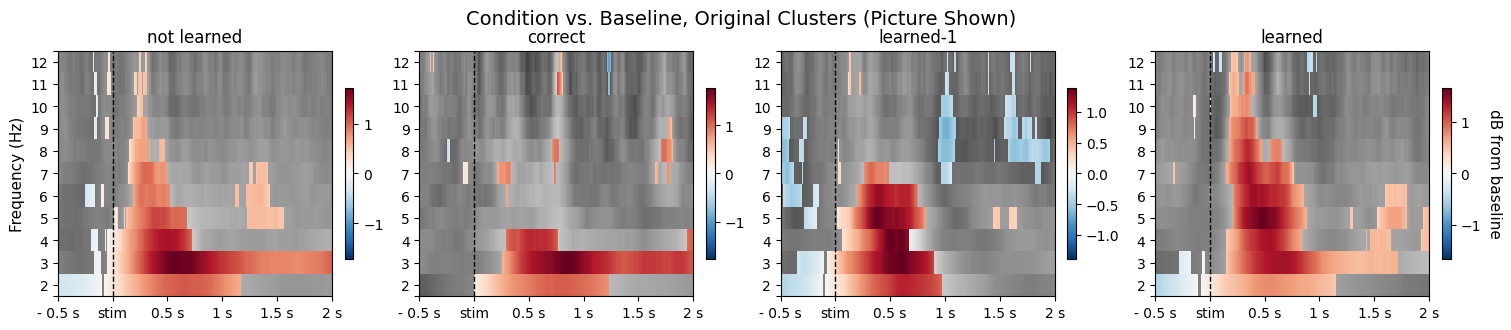

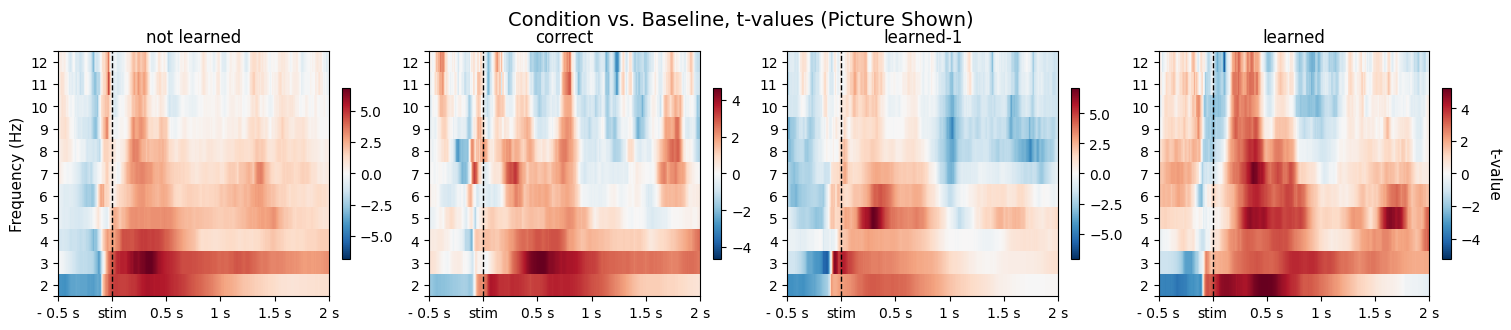

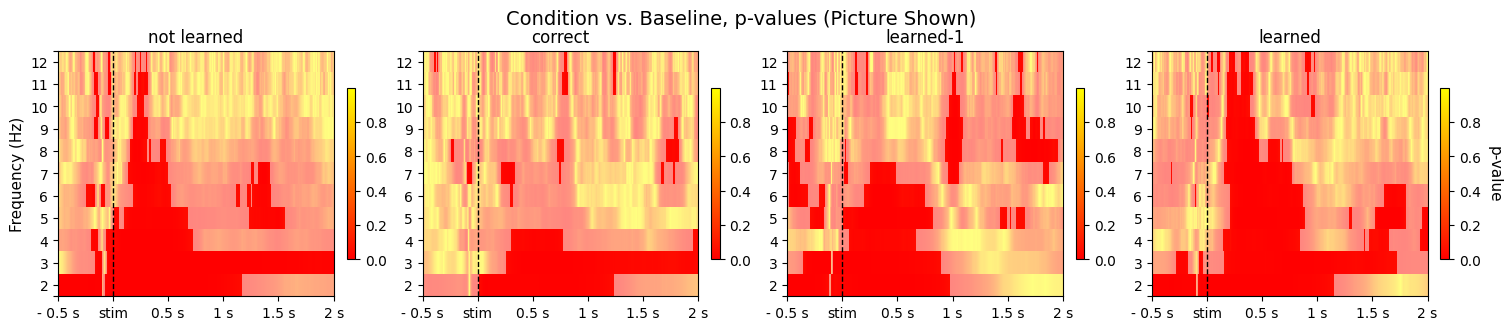

In [124]:
# [INFO] CHANGE IF NEEDED
tfr_data                = dict_tfr_power_results_cond_avg
fname_statistics        = f"2.2 {stimulus}_stat_t_test_condition_vs_baseline.json"
individ_cbars           = True # individual color bars (True/False)
draw_cluster_contours   = False

# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'r') as f:
    statistics = json.load(f)

# convert to numpy arrays
for condition in conditions:
    statistics[condition]['t-statistics'] = np.array(statistics[condition]['t-statistics'])
    statistics[condition]['p-values'] = np.array(statistics[condition]['p-values'])
    statistics[condition]['clusters'] = np.array(statistics[condition]['clusters'])
    statistics[condition]['cluster_labels'] = np.array(statistics[condition]['cluster_labels'])

#********** PLOT RESULTS **********#
fig1, ax1 = plt.subplots(nrows=1, ncols=len(conditions), figsize=(15, 3), layout='compressed')
fig2, ax2 = plt.subplots(nrows=1, ncols=len(conditions), figsize=(15, 3), layout='compressed')
fig3, ax3 = plt.subplots(nrows=1, ncols=len(conditions), figsize=(15, 3), layout='compressed')
for i, condition in enumerate(conditions):
    
    # get statistics
    t_observed = statistics[condition]['t-statistics']
    p_observed = statistics[condition]['p-values']
    
    # find indices where p-value is significant
    idx_freqs, idx_time = np.where(p_observed <= alpha)
    # create mask for all three plots
    tfr_plot_mask   = np.zeros_like(p_observed) if draw_cluster_contours else np.full_like(p_observed, np.nan)
    t_plot_mask     = np.full_like(p_observed, np.nan)
    p_plot_mask     = np.full_like(p_observed, np.nan)
    for f, t in zip(idx_freqs, idx_time):
        tfr_plot_mask[f, t] = 1 if draw_cluster_contours else tfr_data[condition][f, t]
        t_plot_mask[f, t]   = t_observed[f, t]
        p_plot_mask[f, t]   = p_observed[f, t]
        
    
    # ********* TIME-FREQUENCY POWER (original clusters) *********
    if draw_cluster_contours:
        im1 = ax1[i].imshow(
            tfr_data[condition],
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
        ax1[i].contour(
            tfr_plot_mask,
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=1.5
        )
    else:
        ax1[i].imshow(
            tfr_data[condition],
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='gray',
            interpolation='none',
            # alpha=.5
        )
        im1 = ax1[i].imshow(
            tfr_plot_mask,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
    ax1[i].set_title(f'{condition}', fontsize=12)
    ax1[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax1[i].set_yticks(yticks, ylabels, fontsize=10)
    ax1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax1[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    # ********* T-VALUE REPRESENTATION *********
    im2 = ax2[i].imshow(
        t_observed,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(t_observed) if individ_cbars else -1,
        vmax=np.max(t_observed) if individ_cbars else 1,
        cmap='RdBu_r',
        interpolation='none',
    )
    ax2[i].set_title(f'{condition}', fontsize=12)
    ax2[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax2[i].set_yticks(yticks, ylabels, fontsize=10)
    ax2[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax2[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    # ********* P-VALUE REPRESENTATION *********
    ax3[i].imshow(
        p_observed,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=0,
        vmax=np.max(p_observed) if individ_cbars else 1,
        cmap='autumn',
        interpolation='none',
        alpha=.5
    )
    im3 = ax3[i].imshow(
        p_plot_mask,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=0,
        vmax=np.max(p_observed) if individ_cbars else 1,
        cmap='autumn',
        interpolation='none'
    )
    ax3[i].set_title(f'{condition}', fontsize=12)
    ax3[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax3[i].set_yticks(yticks, ylabels, fontsize=10)
    ax3[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax3[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        cbar1 = plt.colorbar(im1, ax=ax1[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar2 = plt.colorbar(im2, ax=ax2[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar3 = plt.colorbar(im3, ax=ax3[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions)-1:
            cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
            cbar2.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=11)
            cbar3.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar1 = plt.colorbar(im1, ax=ax1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar2 = plt.colorbar(im2, ax=ax2.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar3 = plt.colorbar(im3, ax=ax3.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
    cbar2.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=11)
    cbar3.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=11)

# add figure titles
fig1.suptitle(f"Condition vs. Baseline, Original Clusters ({stimulus})", fontsize=14, y=1.05, x=.49)
fig2.suptitle(f"Condition vs. Baseline, t-values ({stimulus})", fontsize=14, y=1.05, x=.49)
fig3.suptitle(f"Condition vs. Baseline, p-values ({stimulus})", fontsize=14, y=1.05, x=.49)

# save figures
fig1.savefig(f"{path_results}/2.2 {stimulus}_stat_condition_vs_baseline_org_clusters.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{path_results}/2.2 {stimulus}_stat_condition_vs_baseline_t_values.png", dpi=300, bbox_inches='tight')
fig3.savefig(f"{path_results}/2.2 {stimulus}_stat_condition_vs_baseline_p_values.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

### 2.3 t-test original clusters: condition vs. condition

In [125]:
# excluding 'correct' condition from tuple as it is not important for analysis and adding new condition 'learned combined'
conditions_diffs    = ('not learned', 'learned-1', 'learned', 'learned combined')
conditions_pairs    = [('learned', 'not learned'), ('learned-1', 'not learned'), ('learned combined', 'not learned'), ('learned', 'learned-1')]
condtion_indices    = {'not learned': 0,
                       'learned-1': 2,
                       'learned': 3,
                       'learned combined': 4}


# ********** ADD CONDITION 'LEARNED COMBINED' TO CONDITIONS RESULTS ********** #
for subject_id in subject_ids:
    dict_tfr_power_results_cond_avg['learned combined'] = np.mean([dict_tfr_power_results_cond_avg[c] for c in ('learned-1', 'learned')], axis=0)
# stack new condtion to array
arr_tfr_power_results_cond_avg = np.vstack((arr_tfr_power_results_cond_avg, dict_tfr_power_results_cond_avg['learned combined'][np.newaxis, :]))


# ********** ADD CONDITION 'LEARNED COMBINED' TO SUBJECTS RESULTS ********** #
dict_tfr_power_results_subj_avg['learned combined'] = {}
for j, subject_id in enumerate(subject_ids):
    dict_tfr_power_results_subj_avg['learned combined'][subject_id] = np.mean([dict_tfr_power_results_subj_avg[c][subject_id] for c in ('learned-1', 'learned')], axis=0)
# stack new condtion to array
tmp_list = []
for subject_id in subject_ids:
    tmp_list.append(dict_tfr_power_results_subj_avg['learned combined'][subject_id])
arr_tfr_power_results_subj_avg = np.vstack((arr_tfr_power_results_subj_avg, np.asanyarray(tmp_list)[np.newaxis, :]))

#### Conduct t-test

- two-sided
- paired / related
- two-sample

In [126]:
tfr_data = dict_tfr_power_results_subj_avg

# get shape of power data (used for constructing matrices to hold cluster labels etc.)
(n_freqs, n_times) = tfr_data[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics      = {f'{condition_a} and {condition_b}': {'t-statistics': None, 'p-values': None, 'clusters': None} for (condition_a, condition_b) in conditions_pairs}

#************ T-TEST ************#
for pair in conditions_pairs:
    condition_a = pair[0]
    condition_b = pair[1]
    if verbose: print(f"Starting paired t-test between conditions {repr(condition_a)} and {repr(condition_b)}...")
    start_time = time.time()
    
    # construct matrices
    t_statistics    = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    p_values        = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    clusters        = np.zeros((n_freqs, n_times))     # 11 frequencies, 1280 time points
    
    # iterate over frequencies and time points
    for i in range(n_freqs):
        for j in range(n_times):
            
            sample_a = []
            sample_b = []
            # for each combination of frequency and time, store the power values for all subjects (all channels have been averaged)
            # this will be used to perform the paired t-test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_a.append(tfr_data[condition_a][subject_id][i, j])
                sample_b.append(tfr_data[condition_b][subject_id][i, j])
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test of time-frequency power between condition A and condition B.
            #   - samples hold time-frequency power for a specific frequency and timepoint combination for each subject (all channels have been averaged together), vector size [n_subjects,]
            #   - sample A holds power values for condition A
            #   - sample B holds power values for condition B
            res = stats.ttest_rel(a=sample_a, b=sample_b, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[i, j]  = res.statistic
            p_values[i, j]      = res.pvalue
            clusters[i, j]      = 1 if res.pvalue <= alpha else 0
    
    # check if clusters were found
    if np.isclose(clusters, 0).all():
        if verbose: print(f"No clusters found.")
        cluster_labels  = np.array([0] * shape[0] * shape[1]).reshape(shape)
        cluster_sizes   = None
    else:
        # assign labels to clusters [REMOVE] replaced by ndimage.label(clusters)
        # cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
        cluster_labels = ndimage.label(clusters)[0]
        
        if 0 not in cluster_labels:
            if verbose: print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
        else:
            if verbose: print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
        
        # count cluster sizes
        cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels, verbose=verbose)
                
    # store current permutation results for condition
    statistics[f'{condition_a} and {condition_b}']['t-statistics'] = t_statistics.tolist()
    statistics[f'{condition_a} and {condition_b}']['p-values'] = p_values.tolist()
    statistics[f'{condition_a} and {condition_b}']['clusters'] = clusters.tolist()
    statistics[f'{condition_a} and {condition_b}']['cluster_labels'] = cluster_labels.tolist()
    statistics[f'{condition_a} and {condition_b}']['cluster_sizes'] = cluster_sizes
          
    if verbose: print(f"Finished paired t-test between {repr(condition_a)} and {repr(condition_b)} in {(time.time() - start_time):.2f} s\n")
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.3 {stimulus}_stat_t_test_condition_vs_condition.json"
with open(filename, 'w') as f:
    print(f"Saving statistics results as {repr(filename)}...")
    json.dump(statistics, f)
    print("Done")

Starting paired t-test between conditions 'learned' and 'not learned'...
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 6.79
	Cluster 2 size: 106.46
	Cluster 3 size: -50.24
	Cluster 4 size: 302.65
	Cluster 5 size: 52.47
	Cluster 6 size: 11.25
	Cluster 7 size: 259.03
	Cluster 8 size: 9.19
	Cluster 9 size: -132.55
	Cluster 10 size: 4.58
	Cluster 11 size: 220.96
	Cluster 12 size: -193.83
	Cluster 13 size: -16.19
	Cluster 14 size: -52.57
	Cluster 15 size: -86.81
	Cluster 16 size: 2.23
	Cluster 17 size: -61.05
	Cluster 18 size: -12.04
	Cluster 19 size: -2.27
	Cluster 20 size: -7.11
	Cluster 21 size: -14.52
Finished paired t-test between 'learned' and 'not learned' in 4.64 s

Starting paired t-test between conditions 'learned-1' and 'not learned'...
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 10.24
	Cluster 2 size: -18.5
	Cluster 3 size: -426.89
	Cluster 4 size: 53.19
	Cluster 5 size: -2734.0
	Cluster

#### Plot

- Time-frequency representation
- t-value matrix
- p-value matrix

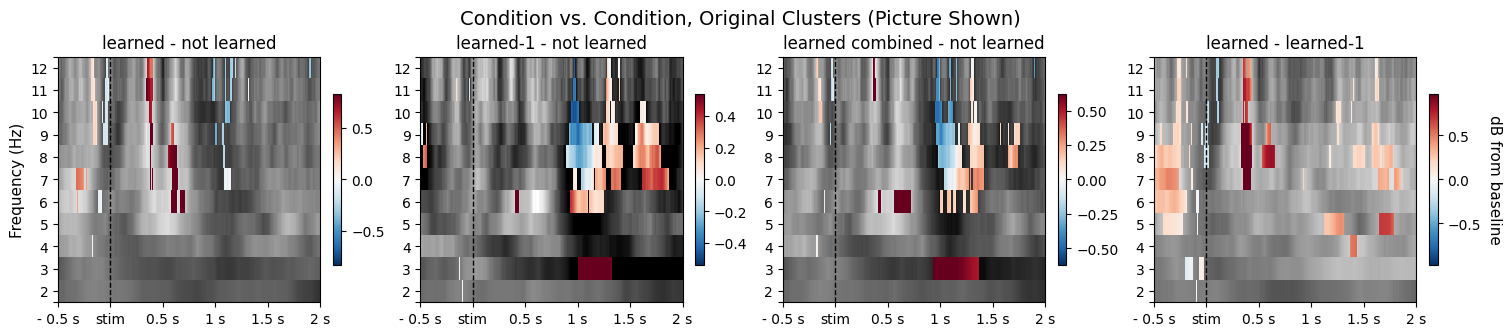

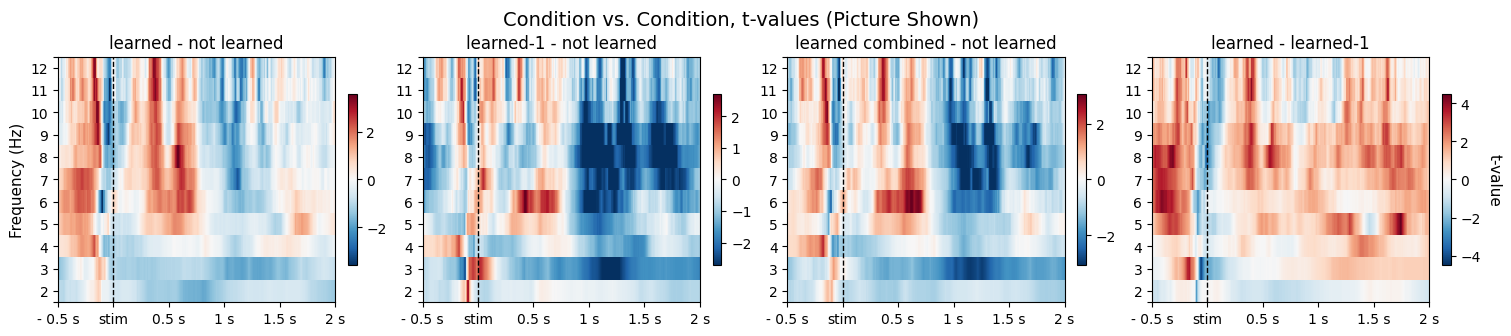

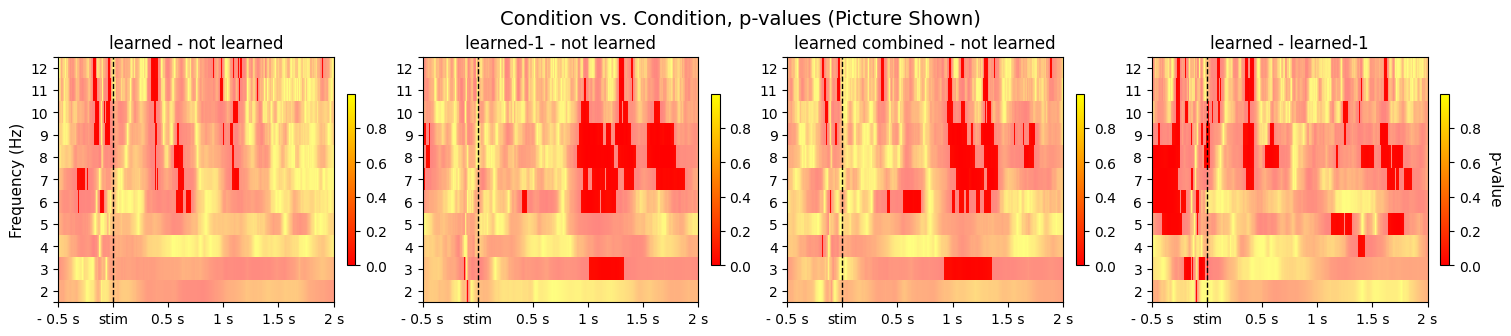

In [127]:
# CHANGE IF NEEDED
tfr_data            = dict_tfr_power_results_cond_avg
fname_statistics    = f"2.3 {stimulus}_stat_t_test_condition_vs_condition.json"
individ_cbars       = True # individual color bars (True/False)
add_cluster_labels  = False # add cluster labels to plot (True/False)
frequencies         = np.arange(2, 13, 1)
frequencies_plot    = np.insert(frequencies.astype(float), 0, 1.5)
frequencies_plot    = np.insert(frequencies_plot, len(frequencies_plot), 12.5)
timepoints          = np.arange(0, 1280, 1)
draw_cluster_contours   = False

# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'r') as f:
    statistics = json.load(f)
    
# convert to numpy arrays
for (condition_a, condition_b) in conditions_pairs:
    statistics[f'{condition_a} and {condition_b}']['t-statistics'] = np.array(statistics[f'{condition_a} and {condition_b}']['t-statistics'])
    statistics[f'{condition_a} and {condition_b}']['p-values'] = np.array(statistics[f'{condition_a} and {condition_b}']['p-values'])
    statistics[f'{condition_a} and {condition_b}']['clusters'] = np.array(statistics[f'{condition_a} and {condition_b}']['clusters'])
    statistics[f'{condition_a} and {condition_b}']['cluster_labels'] = np.array(statistics[f'{condition_a} and {condition_b}']['cluster_labels'])

#********** PLOT RESULTS **********#
fig1, ax1 = plt.subplots(nrows=1, ncols=len(conditions_pairs), figsize=(15, 3), layout='compressed')
fig2, ax2 = plt.subplots(nrows=1, ncols=len(conditions_pairs), figsize=(15, 3), layout='compressed')
fig3, ax3 = plt.subplots(nrows=1, ncols=len(conditions_pairs), figsize=(15, 3), layout='compressed')
for i, (condition_a, condition_b) in enumerate(conditions_pairs):
    
    # difference between condition A and B
    tfr_diff_data = tfr_data[condition_a] - tfr_data[condition_b]
    
    # get statistics
    t_observed = statistics[f'{condition_a} and {condition_b}']['t-statistics']
    p_observed = statistics[f'{condition_a} and {condition_b}']['p-values']
    
    # find indices where p-value is significant
    idx_freqs, idx_time = np.where(p_observed <= alpha)
    # create mask for all three plots
    tfr_plot_mask   = np.zeros_like(p_observed) if draw_cluster_contours else np.full_like(p_observed, np.nan)
    t_plot_mask     = np.full_like(p_observed, np.nan)
    p_plot_mask     = np.full_like(p_observed, np.nan)
    for f, t in zip(idx_freqs, idx_time):
        tfr_plot_mask[f, t] = 1 if draw_cluster_contours else tfr_data[condition][f, t]
        t_plot_mask[f, t]   = t_observed[f, t]
        p_plot_mask[f, t]   = p_observed[f, t]
        
    # ********* TIME-FREQUENCY POWER (original clusters) *********
    if draw_cluster_contours:
        im1 = ax1[i].imshow(
            tfr_diff_data,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
        ax1[i].contour(
            tfr_plot_mask,
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=1.5
        )
    else:
        ax1[i].imshow(
            tfr_diff_data,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='gray',
            interpolation='none',
            # alpha=.5
        )
        im1 = ax1[i].imshow(
            tfr_plot_mask,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
    ax1[i].set_title(f'{condition_a} - {condition_b}', fontsize=12)
    ax1[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax1[i].set_yticks(yticks, ylabels, fontsize=10)
    ax1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax1[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    # ********* T-VALUE REPRESENTATION *********
    im2 = ax2[i].imshow(
        t_observed,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(t_observed) if individ_cbars else -1,
        vmax=np.max(t_observed) if individ_cbars else 1,
        cmap='RdBu_r',
        interpolation='none'
        )
    ax2[i].set_title(f'{condition_a} - {condition_b}', fontsize=12)
    ax2[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax2[i].set_yticks(yticks, ylabels, fontsize=10)
    ax2[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10) # custom x tick labels
    ax2[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    # ********* P-VALUE REPRESENTATION *********
    ax3[i].imshow(
        p_observed,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=0,
        vmax=np.max(p_observed) if individ_cbars else 1,
        cmap='autumn',
        interpolation='none',
        alpha=.5
    )
    im3 = ax3[i].imshow(
        p_plot_mask,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=0,
        vmax=np.max(p_observed) if individ_cbars else 1,
        cmap='autumn',
        interpolation='none'
    )
    ax3[i].set_title(f'{condition_a} - {condition_b}', fontsize=12)
    ax3[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax3[i].set_yticks(yticks, ylabels, fontsize=10)
    ax3[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax3[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        cbar1 = plt.colorbar(im1, ax=ax1[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar2 = plt.colorbar(im2, ax=ax2[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar3 = plt.colorbar(im3, ax=ax3[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions)-1:
            cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
            cbar2.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=11)
            cbar3.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar1 = plt.colorbar(im1, ax=ax1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar2 = plt.colorbar(im2, ax=ax2.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar3 = plt.colorbar(im3, ax=ax3.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
    cbar2.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=11)
    cbar3.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=11)

# add figure titles
fig1.suptitle(f"Condition vs. Condition, Original Clusters ({stimulus})", fontsize=14, y=1.07, x=.49)
fig2.suptitle(f"Condition vs. Condition, t-values ({stimulus})", fontsize=14, y=1.07, x=.49)
fig3.suptitle(f"Condition vs. Condition, p-values ({stimulus})", fontsize=14, y=1.07, x=.49)

# save figures
fig1.savefig(f"{path_results}/2.3 {stimulus}_stat_condition_vs_condition_org_clusters.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{path_results}/2.3 {stimulus}_stat_condition_vs_condition_t_values.png", dpi=300, bbox_inches='tight')
fig3.savefig(f"{path_results}/2.3 {stimulus}_stat_condition_vs_condition_p_values.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

# 3. 1D Analysis

- t-value and p-value plots from 2. are inspected:
    - areas with high t-values and low p-values are chosen as areas-of-interest (AOI).
    - frequency range and time range is selected for the AOI.
- This is done for each condition.

In [128]:
path_results        = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = True

### 3.1 Load Time-Frequency Power Results

In [ ]:
# [REMOVE]

fname_stat_results  = f"{path_results}/data/2.2 {stimulus}_stat_t_test_condition_vs_baseline.json"
# load previously calculated statistics
with open(fname_stat_results, 'rb') as f:
    statistics = pickle.load(f)

In [ ]:
# [IMPORTANT] CHANGE STIMULUS BEFORE RUNNING THIS CELL
stimulus = 'Picture Placed'

# [INFO] load data in this cell once to avoid re-running the heavy loading process. 
fname_tfr_results   = f"{path_results}/data/1.1 tfr_power_results_{stimulus}.pkl"
fname_stat_results  = f"{path_results}/data/2.3 {stimulus}_stat_t_test_condition_vs_condition.json"

# load previously computed time-frequency power for all subjects
with open(fname_tfr_results, 'rb') as f:
    dict_tfr_power_results = pickle.load(f)
    
# load previously calculated statistics
with open(fname_stat_results, 'r') as f:
    statistics = json.load(f)
# convert to numpy arrays
for (condition_a, condition_b) in conditions_pairs:
    statistics[f'{condition_a} and {condition_b}']['t-statistics'] = np.array(statistics[f'{condition_a} and {condition_b}']['t-statistics'])
    statistics[f'{condition_a} and {condition_b}']['p-values'] = np.array(statistics[f'{condition_a} and {condition_b}']['p-values'])
    statistics[f'{condition_a} and {condition_b}']['clusters'] = np.array(statistics[f'{condition_a} and {condition_b}']['clusters'])
    statistics[f'{condition_a} and {condition_b}']['cluster_labels'] = np.array(statistics[f'{condition_a} and {condition_b}']['cluster_labels'])


# get conditions and subject ids from the loaded results dictionary
conditions = list(dict_tfr_power_results.keys())
subject_ids = list(dict_tfr_power_results[conditions[0]].keys())

# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
bool_shape = True
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
            if bool_shape:
                n_freqs = dict_tfr_power_results_chan_avg[condition][subject_id][ch].shape[0]
                n_times = dict_tfr_power_results_chan_avg[condition][subject_id][ch].shape[1]
                bool_shape = False
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions), len(subject_ids), n_freqs, n_times))
for i, condition in enumerate(conditions):
    for j, subject_id in enumerate(subject_ids):
        dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
        
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions), n_freqs, n_times))
for i, condition in enumerate(conditions):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
    
# ********** ADD CONDITION 'LEARNED COMBINED' TO CONDITIONS RESULTS ********** #
for subject_id in subject_ids:
    dict_tfr_power_results_cond_avg['learned combined'] = np.mean([dict_tfr_power_results_cond_avg[c] for c in ('learned-1', 'learned')], axis=0)
# stack new condtion to array
arr_tfr_power_results_cond_avg = np.vstack((arr_tfr_power_results_cond_avg, dict_tfr_power_results_cond_avg['learned combined'][np.newaxis, :]))
    
# clean up to save memory
del dict_tfr_power_results

### 3.2 Cut time-frequency data and average to 1D 

In [130]:
def cut_tfr_data(tfr_data_condition, freq_start, freq_end, time_start, time_end):
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end)[0][0].astype(int)

    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    
    # cut time-frequency power data and average flattened array
    tfr_data_condition_cut = np.mean(tfr_data_condition[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_condition_cut, freq_start_idx, freq_end_idx, time_start_idx, time_end_idx

Frequency range:	3 - 5 Hz
Time range:		1.0 - 1.5 s
Frequency indices:	1 - 3
Time indices:		767 - 1023


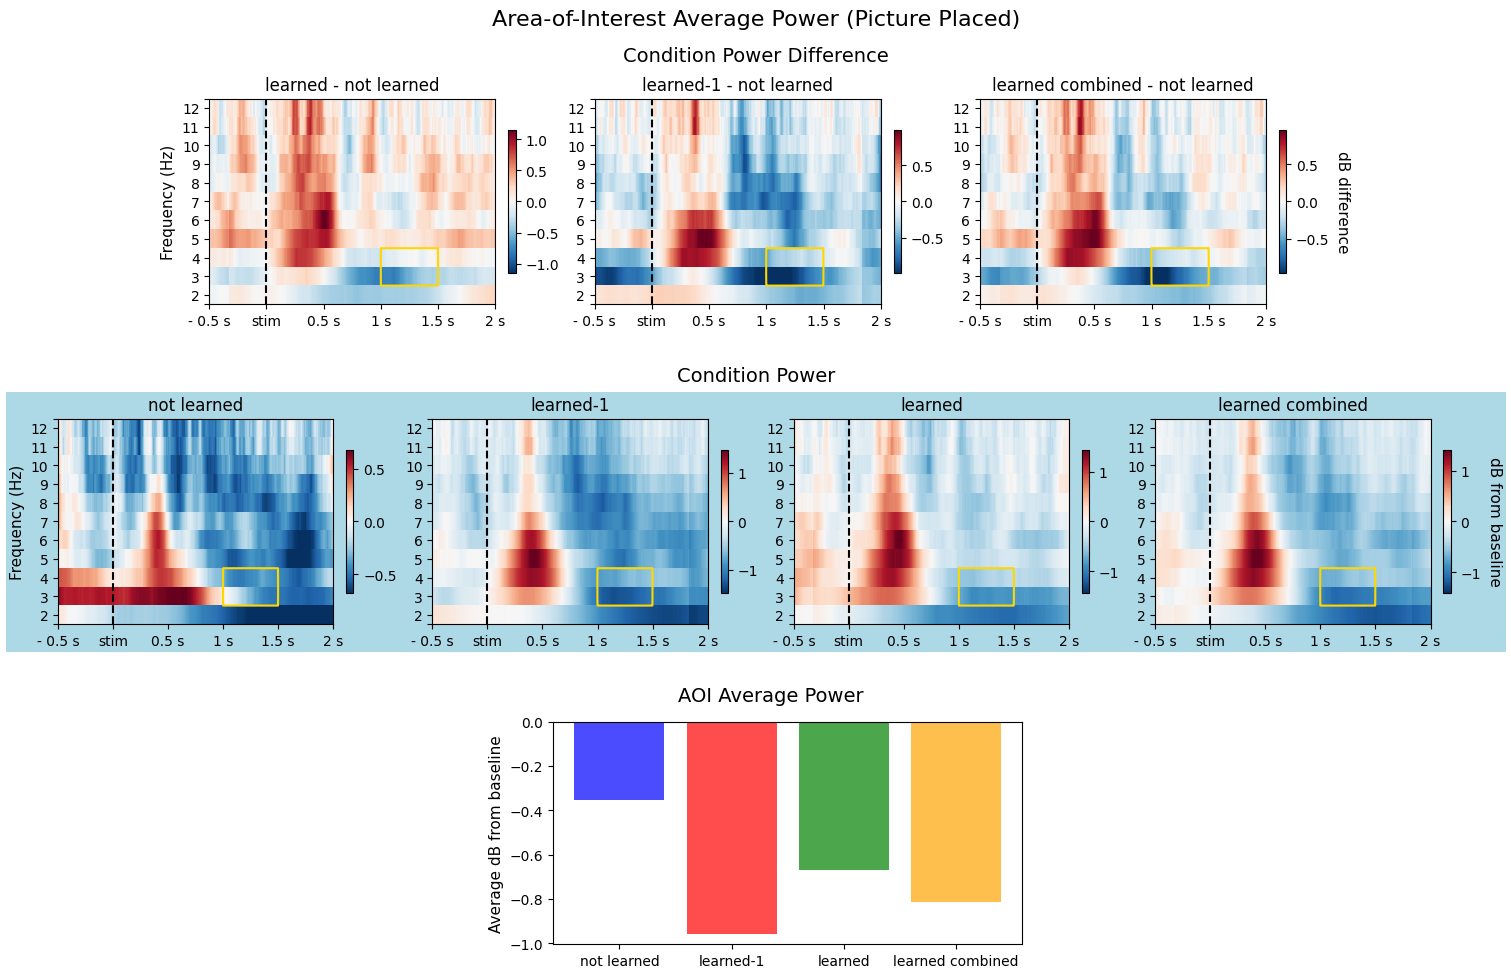

In [166]:
# [IMPORTANT] CHANGE AS NEEDED:
#   - condition: condition to cut data from
#   - freq_start, freq_end: frequency range to cut data from
#   - time_start, time_end: time range to cut data from
conditions_to_cut       = ['not learned', 'learned-1', 'learned', 'learned combined']
condition_pairs         = [('learned', 'not learned'), ('learned-1', 'not learned'), ('learned combined', 'not learned'), (None, None)]
freq_start, freq_end    = 3, 5      # frequency range to cut (in Hz)
time_start, time_end    = 1., 1.5   # time range to cut (in seconds)

# common parameters
individ_cbars       = True
fs                  = 512
stimulus_onset      = 255

# initialize dictionary to store cut data
tfr_data_cut = {f'{condition}': None for condition in conditions_to_cut}

if verbose:
    print(f"Frequency range:\t{freq_start} - {freq_end} Hz")
    print(f"Time range:\t\t{time_start} - {time_end} s")
    print(f"Frequency indices:\t{freq_start_idx} - {freq_end_idx}")
    print(f"Time indices:\t\t{time_start_idx} - {time_end_idx}")


# initialize figure
fig = plt.figure(figsize=(15, 9), layout="constrained")
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.2)
# FIGURE 1: time-frequency power (condition difference)
gs_kw = dict(width_ratios=[0.5, 1, 1, 1, 0.5])
axs0 = subfigs[0].subplots(nrows=1, ncols=len(conditions_to_cut)+1, gridspec_kw=gs_kw)
axs0 = axs0.flatten()
axs0[0].axis('off')
axs0[-1].axis('off')
axs0 = axs0[1:-1]
# FIGURE 2: time-frequency power (individual condition)
axs1 = subfigs[1].subplots(nrows=1, ncols=len(conditions_to_cut))
axs1 = axs1.flatten()
subfigs[1].set_facecolor('lightblue')
# FIGURE 3: bar plot
axs2 = subfigs[2].subplots(nrows=1, ncols=len(conditions_to_cut)-1)
axs2 = axs2.flatten()

for i, (condition, (pair_a, pair_b)) in enumerate(zip(conditions_to_cut, condition_pairs)):
    # get time-frequency power data for condition
    tfr_data_condition  = dict_tfr_power_results_cond_avg[condition]
    
    # get time-frequency power difference between pair of conditions
    if pair_a is not None:
        tfr_data_diff   = dict_tfr_power_results_cond_avg[pair_a] - dict_tfr_power_results_cond_avg[pair_b]
    
    # cut data
    tfr_data_cut[condition], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx = cut_tfr_data(tfr_data_condition, freq_start, freq_end, time_start, time_end)
    
    # create a mask of same shape as tfr_data_condition
    # with power values where the data is to be cut and nan elsewhere
    # mask = np.full_like(tfr_data_condition, np.nan)
    # mask[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx] = tfr_data_condition[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx]
    # create a mask of same shape as tfr_data_condition
    # binary - for drawing contour
    mask = np.zeros_like(tfr_data_condition)
    mask[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx] = 1

    # ****** PLOT CONDITION DIFFERENCE ****** #
    if pair_a is not None:
        im0 = axs0[i].imshow(
            tfr_data_diff, 
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            vmax=np.max(tfr_data_diff),
            vmin=-np.max(tfr_data_diff),
            aspect='auto', 
            origin='lower', 
            cmap='RdBu_r', 
            interpolation='none')
        axs0[i].contour(
            mask, 
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=1.5)
        axs0[i].set_title(f"{pair_a} - {pair_b}", fontsize=12)
        axs0[0].set_ylabel("Frequency (Hz)", fontsize=11)
        axs0[i].set_yticks(yticks, ylabels, fontsize=10)
        axs0[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
        axs0[i].axvline(x=255, color='black', linestyle='--', linewidth=1.5) # add line at stimulus onset
    else:
        pass
    
    # ****** PLOT INDIVIDUAL CONDITION ****** #
    im1 = axs1[i].imshow(
        tfr_data_condition, 
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        vmax=np.max(tfr_data_condition),
        vmin=-np.max(tfr_data_condition),
        aspect='auto', 
        origin='lower', 
        cmap='RdBu_r', 
        interpolation='none')
    axs1[i].contour(
        mask, 
        colors='gold', 
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=1.5)
    axs1[i].set_title(f"{condition}", fontsize=12)
    axs1[0].set_ylabel("Frequency (Hz)", fontsize=11)
    axs1[i].set_yticks(yticks, ylabels, fontsize=10)
    axs1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    axs1[i].axvline(x=255, color='black', linestyle='--', linewidth=1.5) # add line at stimulus onset
    
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        if pair_a is not None: cbar0 = plt.colorbar(im0, ax=axs0[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar1 = plt.colorbar(im1, ax=axs1[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions_to_cut)-2: cbar0.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
        if i == len(conditions_to_cut)-1: cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar0 = plt.colorbar(im0, ax=axs0.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1 = plt.colorbar(im1, ax=axs1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar0.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
    cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# ****** BAR PLOT ****** #
axs2[0].axis('off')
axs2[2].axis('off')
axs2[1].bar(conditions_to_cut, tfr_data_cut.values(), color=['blue', 'red', 'green', 'orange'], alpha=0.7)
axs2[1].set_ylabel("Average dB from baseline", fontsize=11)

# set subfigure titles
fig.suptitle(f"Area-of-Interest Average Power ({stimulus})", fontsize=16, y=1.07)
subfigs[0].suptitle(f"Condition Power Difference", fontsize=14, y=1.10)
subfigs[1].suptitle(f"Condition Power", fontsize=14, y=1.10)
subfigs[2].suptitle(f"AOI Average Power", fontsize=14, y=1.10, x=0.51)

# save figure
fig.savefig(f"{path_results}/3.2 {stimulus}_mask_tfr_data_cut.png", dpi=300, bbox_inches='tight')

plt.show()

# save cut data
with open(f"{path_results}/data/3.2 {stimulus}_tfr_data_cut___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.pkl", 'wb') as f:
    pickle.dump(tfr_data_cut, f)

### 3.3 Statistics of 1D cut data

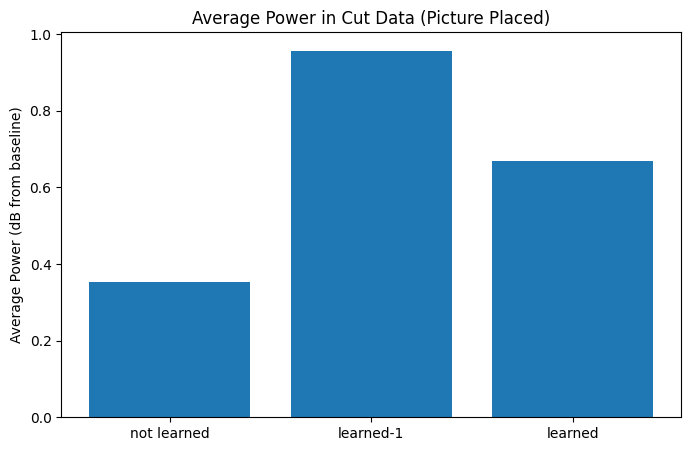

In [ ]:
# Load cut data for stimulus
fname_cut_data  = f"{path_results}/data/3.2 {stimulus}_tfr_data_cut.pkl"
with open(fname_cut_data, 'rb') as f:
    tfr_data_cut = pickle.load(f)

conditions_cut = tfr_data_cut.keys()

tfr_cut = []
tfr_conds = []
for condition, value in tfr_data_cut.items():
    tfr_cut.append(abs(value))
    tfr_conds.append(condition)
    
# bar plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(tfr_conds, tfr_cut)
ax.set_ylabel("Average Power (dB from baseline)")
ax.set_title(f"Average Power in Cut Data ({stimulus})")

# save figure
fig.savefig(f"{path_results}/3.3 {stimulus}_bar_tfr_data_cut.png", dpi=300, bbox_inches='tight')

plt.show()